Functional api는 케라스를 low level로 쓸 수 있기 위함 
- 기존의 케라스 모델 정의 방식은 model을 선언하고 model.add를 통해 layer를 추가해 감 
- 커스터마이징이 쉽지 않음 
- functional api 는 모델 설계를 더 유기적으로 가능케 함 
- model fit 부터는 동일 

# 기본 CNN 모형 비교 

## 기존 모델 설계 

In [ ]:
model = keras.Sequential()
model.add(Input((28,28,1)))
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


model.fit(train_x, train_y, epochs=5, verbose=1, batch_size=128)

## Functional api 

In [ ]:
from tensorflow.keras import Model

input = Input((28,28,1))
x = Conv2D(32, (3,3))(input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, (3,3))(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(10, activation='relu')(x)
x = Dense(10, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(input, output)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


model.fit(train_x, train_y, epochs=5, verbose=1, batch_size=128)

# Functional Api 활용 - 다중 입력 
- 인풋 데이터를 이미지, 속성 데이터 두개를 이용 해 아웃 풋 예측 
- 집 사진과 정보로 집값 예측 

## 데이터 로드 

In [8]:
!git clone https://github.com/emanhamed/Houses-dataset

Cloning into 'Houses-dataset'...
remote: Enumerating objects: 2166, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 2166 (delta 0), reused 0 (delta 0), pack-reused 2165
Receiving objects: 100% (2166/2166), 176.26 MiB | 40.42 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [11]:
import matplotlib

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os

In [10]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import glob
import cv2
import os

In [ ]:


def load_house_attributes(inputPath): #<-------------데이터 로드 용 함수 

	cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
	df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)
 
	# determine (1) the unique zip codes and (2) the number of data
	# points with each zip code
	zipcodes = df["zipcode"].value_counts().keys().tolist()
	counts = df["zipcode"].value_counts().tolist()
 
	# loop over each of the unique zip codes and their corresponding
	# count
	for (zipcode, count) in zip(zipcodes, counts):
		# the zip code counts for our housing dataset is *extremely*
		# unbalanced (some only having 1 or 2 houses per zip code)
		# so let's sanitize our data by removing any houses with less
		# than 25 houses per zip code
		if count < 25:
			idxs = df[df["zipcode"] == zipcode].index
			df.drop(idxs, inplace=True)
   
	# return the data frame
	return df

def process_house_attributes(df, train, test):
	# initialize the column names of the continuous data
	continuous = ["bedrooms", "bathrooms", "area"]

	# performin min-max scaling each continuous feature column to
	# the range [0, 1]
	cs = MinMaxScaler()
	trainContinuous = cs.fit_transform(train[continuous])
	testContinuous = cs.transform(test[continuous])
 
	# one-hot encode the zip code categorical data (by definition of
	# one-hot encoding, all output features are now in the range [0, 1])
	zipBinarizer = LabelBinarizer().fit(df["zipcode"])
	trainCategorical = zipBinarizer.transform(train["zipcode"])
	testCategorical = zipBinarizer.transform(test["zipcode"])
 
	# construct our training and testing data points by concatenating
	# the categorical features with the continuous features
	trainX = np.hstack([trainCategorical, trainContinuous])
	testX = np.hstack([testCategorical, testContinuous])
 
	# return the concatenated training and testing data
	return (trainX, testX)  

In [ ]:
def load_house_images(df, inputPath): #<------------- 데이터 로드 용 함수 

	# initialize our images array (i.e., the house images themselves)
	images = []

	# loop over the indexes of the houses
	for i in df.index.values:
		# find the four images for the house and sort the file paths,
		# ensuring the four are always in the *same order*
		basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
		housePaths = sorted(list(glob.glob(basePath)))
  
		# initialize our list of input images along with the output image
		# after *combining* the four input images
		inputImages = []
		outputImage = np.zeros((64, 64, 3), dtype="uint8")
  
		# loop over the input house paths
		for housePath in housePaths:
			# load the input image, resize it to be 32 32, and then
			# update the list of input images
			image = cv2.imread(housePath)
			image = cv2.resize(image, (32, 32))
			inputImages.append(image)
   
		# tile the four input images in the output image such the first
		# image goes in the top-right corner, the second image in the
		# top-left corner, the third image in the bottom-right corner,
		# and the final image in the bottom-left corner
		outputImage[0:32, 0:32] = inputImages[0]
		outputImage[0:32, 32:64] = inputImages[1]
		outputImage[32:64, 32:64] = inputImages[2]
		outputImage[32:64, 0:32] = inputImages[3]

		# add the tiled image to our set of images the network will be
		# trained on
		images.append(outputImage)
  
	# return our set of images
	return np.array(images)  

### 속성 데이터 

In [ ]:
df = load_house_attributes("Houses-dataset/Houses Dataset/HousesInfo.txt")

In [ ]:
df.head()

,bedrooms,bathrooms,area,zipcode,price
30,5,3.0,2520,93446,789000
32,3,2.0,1802,93446,365000
39,3,3.0,2146,93446,455000
80,4,2.5,2464,91901,599000
81,2,2.0,1845,91901,529800


### 이미지 데이터 
- 전처리(리사이즈, 정규화)모두 완료 

In [ ]:
images = load_house_images(df, "Houses-dataset/Houses Dataset/")
images = images/255.

In [ ]:
print(images.shape)

(362, 64, 64, 3)


## 데이터 분할 

In [ ]:
maxPrice

5858000

In [ ]:
(trainAttrX, testAttrX, trainImagesX, testImagesX) = train_test_split(df, images, test_size=0.25, random_state=42)

maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice
(trainAttrX, testAttrX) = process_house_attributes(df, trainAttrX, testAttrX)

In [ ]:
print("tainAttrX.shape=", trainAttrX.shape)
print("trainImagesX.shape=", trainImagesX.shape)
print("trainY.shape=", trainY.shape)
print('-'*50)
print("testAttrX.shape=", testAttrX.shape)
print("testImageX.shape=", testImagesX.shape)
print("testY.shape=", testY.shape)

tainAttrX.shape= (271, 10)
trainImagesX.shape= (271, 64, 64, 3)
trainY.shape= (271,)
--------------------------------------------------
testAttrX.shape= (91, 10)
testImageX.shape= (91, 64, 64, 3)
testY.shape= (91,)


- 10개의 속성 데이터, 그리고 이미지를 이용 해 집값 trainY를 예측하는 것임

In [ ]:
train_x = trainAttrX
train_y = trainY.to_numpy()
test_x = testAttrX
test_y = testY.to_numpy()

## 다중 입력 모델로 모델링 <---- 여기가 가장 중요 

In [7]:
# import the necessary packages
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate

In [ ]:
# 속성 데이터 파트 
attr_input = Input(trainAttrX[0].shape) #<----- 속성 데이터 input 

x = Dense(10, activation='relu')(attr_input)
attr_out = Dense(10, activation='linear')(x) #<---- 속성 데이터 output


# 이미지 데이터 파트 
image_input = Input(trainImagesX[0].shape)
x = Conv2D(32, (3,3))(image_input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, (3,3))(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(10, activation='relu')(x)
image_output = Dense(10, activation='linear')(x)

combined_input = concatenate([attr_out, image_output])

x = Dense(4, activation="relu")(combined_input)
output = Dense(1)(x)


combined_model = Model([attr_input, image_input], output) #<---- 이미지 인풋, 속성 인풋 그리고 혼합 아웃풋 입력 

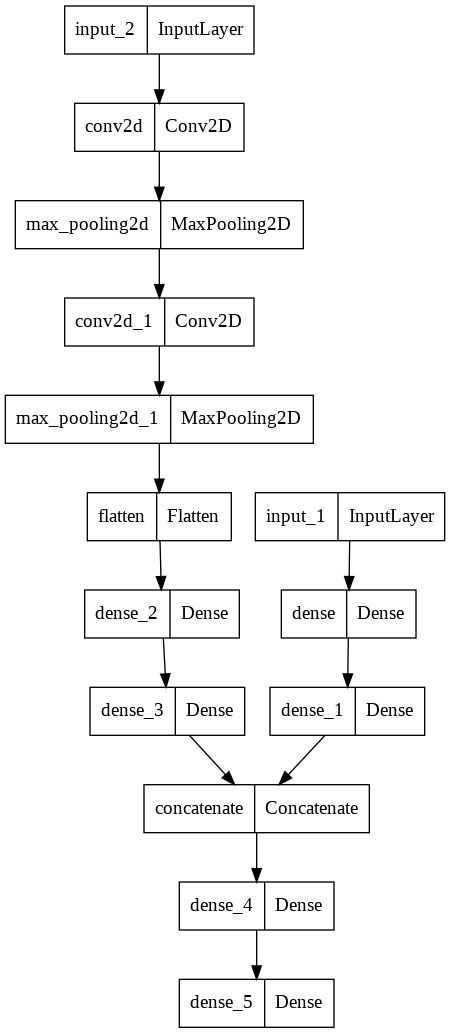

In [ ]:
#모델 설계 구조 
import tensorflow 
tensorflow.keras.utils.plot_model(combined_model)

In [ ]:
#학습 방식은 동일 
combined_model.compile(optimizer="adam", loss="mse",metrics = ['mape'])
combined_model.summary()

combined_model.fit([trainAttrX, trainImagesX], trainY, epochs=100, verbose=0, batch_size=128)

In [ ]:
preds = combined_model.predict([testAttrX, testImagesX]) #<----예측할 때도 이미지, 속성을 둘다 넣어 줌 

diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

print("[INFO] mean: {:.2f}%, std: {:.2f}".format(mean, std))

[INFO] mean: 26.44%, std: 26.07


In [ ]:
test_y = np.array(testY*maxPrice)

In [ ]:
predicted = (preds*maxPrice).astype(np.int)

# Functional Api 활용 - 다중 출력


## 데이터 로드 

In [ ]:
!wget https://github.com/dhrim/MDC_2021/raw/master/material/deep_learning/fashion_dataset.zip
!unzip fashion_dataset.zip

In [2]:
IMAGE_DIMS = (96, 96, 3)

In [13]:
# 이미지 리스트 불러 오기 
imagePaths = sorted(list(paths.list_images('fashion_dataset'))) #<- 해당 디렉토리의 모든 images 파일 리스트를 불러 옴 
random.shuffle(imagePaths) #<--- 믹싱 
print(len(imagePaths)) #<--- 파일 갯수 
print(imagePaths[:3]) #<---- 샘플 확인 

755
['fashion_dataset/black_jeans/00000057.jpg', 'fashion_dataset/red_dress/00000158.jpg', 'fashion_dataset/blue_dress/00000109.jpg']


In [14]:
#이미지 파일 데이터 불러 오기 
data = []
categoryLabels = []
colorLabels = []

for imagePath in imagePaths:
	image = cv2.imread(imagePath) #<--- 데이터 불러 오기 
	image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0])) #<--- 리사이즈
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #<--- 컬러 체계 변경 
	image = img_to_array(image) #<--- 어레이 형태로 
	data.append(image)

	(color, cat) = imagePath.split(os.path.sep)[-2].split("_") 
  # imagePath = 'fashion_dataset/black_shoes/00000048.jpg' <--- 폴더, 폴더, 파일로 자른 뒤 black, shoes를 나눔 
  # color = 'black'
  # cat = 'shoes' <----- 이 색깔과 카테고리가 y 값이 됨 
	categoryLabels.append(cat)
	colorLabels.append(color)
data=  np.array(data)
categoryLabels = np.array(categoryLabels)
colorLabels = np.array(colorLabels)

### 데이터 확인 

In [15]:
print(categoryLabels[:10])
print(colorLabels[:10])

['jeans' 'dress' 'dress' 'shirt' 'dress' 'dress' 'dress' 'shoes' 'shirt'
 'shoes']
['black' 'red' 'blue' 'blue' 'red' 'red' 'blue' 'black' 'blue' 'black']


755 755 755
iamgePaths[0]= fashion_dataset/black_jeans/00000057.jpg


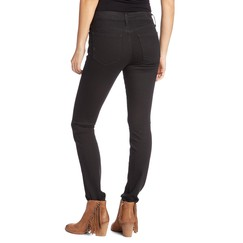

data[0]= (96, 96, 3)
categoryLabels[0]= jeans
colorLabels[0]= black


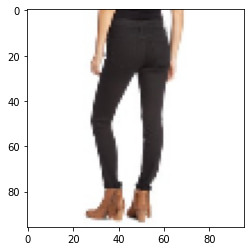

In [19]:
from IPython.display import Image, display

#전처리 전 
print(len(data), len(categoryLabels), len(colorLabels))
print("iamgePaths[0]=", imagePaths[0])
display(Image(imagePaths[0]))

#전처리 후 
print("data[0]=", data[0].shape)
plt.imshow(data[0]/255)
print("categoryLabels[0]=", categoryLabels[0])
print("colorLabels[0]=", colorLabels[0])

## 전처리 

### 정규화

In [20]:
data = data/255.

### 원핫 인코딩

In [21]:
print(categoryLabels[:5])
categoryLB = LabelBinarizer()
categoryLabels = categoryLB.fit_transform(categoryLabels)
print(categoryLabels[:5])


print(colorLabels[:5])
colorLB = LabelBinarizer()
colorLabels = colorLB.fit_transform(colorLabels)
print(colorLabels[:5])

['jeans' 'dress' 'dress' 'shirt' 'dress']
[[0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [1 0 0 0]]
['black' 'red' 'blue' 'blue' 'red']
[[1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 0 1]]


### 데이터 분리 

In [22]:
(trainX, testX, trainCategoryY, testCategoryY, trainColorY, testColorY) = train_test_split(data, categoryLabels, colorLabels, test_size=0.2, random_state=42)

print(trainX.shape)
print(trainCategoryY.shape)
print(trainColorY.shape)

print(testX.shape)
print(testCategoryY.shape)
print(testColorY.shape)

(604, 96, 96, 3)
(604, 4)
(604, 3)
(151, 96, 96, 3)
(151, 4)
(151, 3)


In [23]:
CATEGORY_COUNT = categoryLabels.shape[-1]
COLOR_COUNT = colorLabels.shape[-1]

print(CATEGORY_COUNT)
print(COLOR_COUNT)

4
3


## 다중 출력 모델 <----- 여기만 사용하면 됨 

In [24]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input


def common_input_branch(input): #<----- 이미지 인풋 

  x = Conv2D(32, (3, 3))(input)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(64, (3, 3))(x)
  x = MaxPooling2D((2, 2))(x)
  x = Flatten()(x)

  return x


def category_branch(x): #<------ 카테고리 아웃풋 

  x = Dense(10, activation='relu')(x)
  x = Dense(10, activation='relu')(x)
  x = Dense(CATEGORY_COUNT, activation='softmax', name='category_output')(x)

  return x

def color_branch(x): #<------색상 아웃 풋 

  x = Dense(10, activation='relu')(x)
  x = Dense(10, activation='relu')(x)
  x = Dense(COLOR_COUNT, activation='softmax', name='color_output')(x)

  return x

In [25]:
input = Input(IMAGE_DIMS)

common_input = common_input_branch(input)
category_output = category_branch(common_input)
color_output = color_branch(common_input)

multi_output_model = Model(input, [category_output, color_output])

multi_output_model.summary()
# 이 다음은 이전의 모델과 동일 함 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 94, 94, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 47, 47, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 45, 45, 64)   18496       ['max_pooling2d[0][0]']          
                                                                                              

In [ ]:
losses = { "category_output":"categorical_crossentropy", "color_output":"categorical_crossentropy"}
loss_weights = { "category_output":1.0, "color_output":1.0}

# color_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
multi_output_model.compile(optimizer="adam", loss=losses, loss_weights=loss_weights, metrics=["accuracy"])


# color_model.fit(trainX, trainColorY, epochs=5, verbose=1, batch_size=128)
multi_output_model.fit(trainX, {"category_output":trainCategoryY, "color_output":trainColorY}, epochs=50, verbose=1, batch_size=128)

In [ ]:
loss, category_loss, color_loss, category_acc, color_acc = multi_output_model.evaluate(testX, {"category_output":testCategoryY, "color_output":testColorY})
print("loss=",loss)
print("categoyr_loss=", category_loss)
print("color_loss=", color_loss)
print("category_acc=", category_acc)
print("color_acc=", color_acc)